# __FyTok__ Quick Start


## 介绍
__FyTok__ 用于执行集成计算。 

In [1]:
import os 
os .environ["FY_VERBOSE"]="info"

import numpy as np
from fytok.tokamak import Tokamak
from fytok.modules.core_profiles import CoreProfiles
from fytok.modules.equilibrium import Equilibrium
from spdm.core.path import Path
from spdm.core.function import Function
from spdm.view import  sp_view


2024-05-31 10:09:11,468 [   fytok]     INFO: Failed to import IMAS wrapper. Using dummy ontology as fallback.
2024-05-31 10:09:11,833 [   fytok]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU @ Institute of Plasma Physics Chinese Academy of Sciences 
            
 version = 0.4.1  (spdm=beta extension=0.2.3.dev0+g2cc21ff.d20240223)

 Run by salmon at 2024-05-31T10:09:11.467314.
 Job ID: fytok_salmon_surface_29035

###################################################################################################



## 导入基准数据 （ITER 15MA）

In [2]:
core_profiles_astra = CoreProfiles(f"file+iterprofiles://./data/15MA Inductive at burn-ASTRA.xls#core_profiles")

core_profiles_1d_astra = core_profiles_astra.time_slice.current.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://./data/g900003.00230_ITER_15MA_eqdsk16VVHR.txt#equilibrium")

## 创建 Tokamak 实例

初始化信息包括

| 参数                               | 解释                                                                                                                                                                                                |
| ---------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| "f""                | 数据源。指向一个 geqdsk 文件(file+geqdsk://...)，提供平衡信息,或者数据源的entry入口                                                                                                                                                          |
| device="name"                      | 指定装置名称。根据装置名称，可以自动调取装置的静态信息，例如，wall.limiter 的几何形状，pf_active.coils 极向场线圈的位置等等。默认支持的装置信息，括 EAST、ITER 和 D3D，可通过配置文件扩展其他装置。 |
| shot=900003 ，                     | 指定放电的炮号。若数据源包含实验数据库，会自动读取相应的炮号作为数据。                                                                                                                              |
| run=0                              | 指定模拟运行的编号。若数据源中包含可写入的是模拟数据库，写入模拟结果是会作为数据 index 的一部分。                                                                                                   |
| equilibrium={"code.name: "fy_eq" } | 指定子模块 equilibrium 的初始化信息。其中 code.name="fy_eq"，意为调用路径 `fytok.modules.equilibrium.fy_eq` 下的插件                                                                                |
| transport_solver={"code.name: "fy_trans" } | 指定子模块 transport_solver 的初始化信息。其中 code.name="fy_trans"，意为调用路径 `fytok.modules.equilibrium.fy_trans` 下的插件                                                                                |
| core_sources={"code.name: "genray" } | 指定子模块 core_sources 的初始化信息。其中 code.name="genray"，意为调用第三方物理模块genray                                                                                |
| core_transport="model": [ {"code": {"name": "dummy"}},,] | 指定子模块 core_transport 的初始化信息。其中 code.name意在调用计算输运系数的模块                                                                              |
| ...... | ......   |



## 初始化 Tokamak 实例



In [3]:
tokamak = Tokamak(
    device="iter",
    shot=900003,
    equilibrium=f"file+geqdsk://./data/g900003.00230_ITER_15MA_eqdsk16VVHR.txt#equilibrium",
    core_transport={
        "model": [
            {"code": {"name": "predefined"}},
            {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            f"file+iterprofiles://./data/15MA Inductive at burn-ASTRA.xls#core_sources/source/0",
            {"code": {"name": "collisional_equipartition"}},
            {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"], "heating": True}}},
            # {"code": {"name": "radiation"}},
            # {"code": {"name": "synchrotron_radiation"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "discontinuity": [0.96, 0.995],
                "dc_pos": 0.96,
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "psi_norm": 1,
                    "psi_norm_flux": -0.1,
                    "*/density": 1.0e19,
                    "*/density_flux": 1.0e23,
                    "*/temperature": 1.0e4,
                    "*/temperature_flux": 1.0e26,
                    # "ion/alpha/density": 1.0e14,
                    # "ion/alpha/density_flux": 1.0e16,
                    # "ion/He/density": 1.0e15,
                    # "ion/He/density_flux": 1.0e15,
                },
            },
        },
        "ion_thermal": ["D", "T"],  #
        "ion_non_thermal": ["alpha", "He"],
        "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            "psi_norm"                  : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)

## 展示概要信息

展示模拟的概要信息，包括 
- 装置名称、炮号、运行序号，
- 使用者、运行环境、运行时间、采用的 Ontology 版本
- 调用的模块信心

In [4]:
print(tokamak.brief_summary)


###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU @ Institute of Plasma Physics Chinese Academy of Sciences 
            
 version = 0.4.1  (spdm=beta extension=0.2.3.dev0+g2cc21ff.d20240223)

 Run by salmon at 2024-05-31T10:09:11.467314.
 Job ID: fytok_salmon_surface_29035

###################################################################################################

---------------------------------------------------------------------------------------------------
                                                Brief Summary
---------------------------------------------------------------------------------------------------
Dataset Description:
 
    Device: ITER, Shot: 900003, Run: 0, 
    Run by Salmon on Surface at 2024-05-3

## 可视化
### 适用于 JupyterLab 环境的可视化接口
FyTok 提供了适用于 JupyterLab 环境的可视化接口，`sp_view.display()`调用。默认情况下，`Tokamak` 会将能够获取到的信息尽可能绘制到一张图上。如下图，展示了 pf_active 极向场线圈、magnetic 磁场探针，wall.limiter 壁, interferometer 干涉仪的几何信息，磁平衡信息给出了二维磁面的等高线，最外层磁面、磁轴、X-point等信息。

```{note} 
具有 IDS 可视化语义的 IDS 都应支持 `sp_view.display()` 可视化，如 wall,pf_active,equilibrium。关于可视化库 spdm.view 的进一步细节请参考第二部分 SpDM 的可视化章节。
```

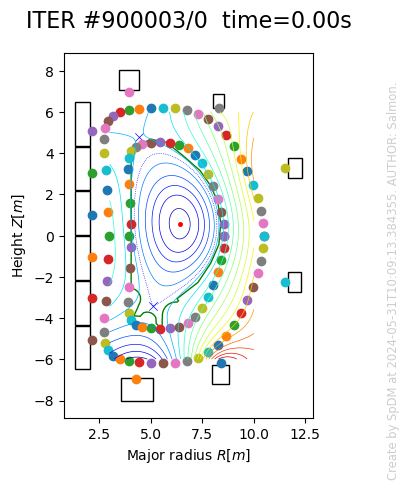

In [5]:
fig=sp_view.display(tokamak)

## 将可视化结果输出为图像文件

通过指定输出文件路径 `output=f"output/{tok.tag}_rz.svg"`，可以将可视化结果以文件的形式保存。

In [6]:
sp_view.display(tokamak, title=tokamak.title, output=f"output/{tokamak.tag}_rz.svg")

输出的文件如下

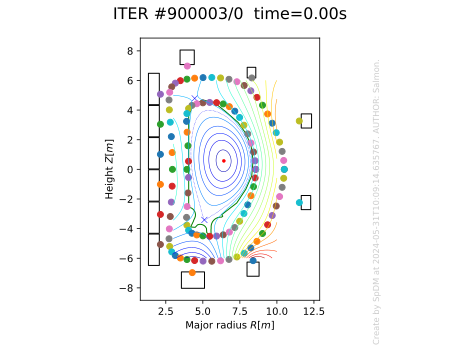

In [7]:
from IPython.core.display import SVG
SVG(f"output/{tokamak.tag}_rz.svg")

In [8]:
tokamak.initialize()

TypeError: Can not convert tags.not_found(<flag 'tags'>) to <class 'spdm.core.edge.Port'>

In [ ]:
tokamak.refresh()

In [ ]:
rho_tor_norm_bdry=0.995
rho_tor_norm = np.linspace(0.001,rho_tor_norm_bdry, 128)
eq_grid = tokamak.equilibrium.time_slice.current.profiles_1d.grid.remesh(rho_tor_norm)
psi_norm = eq_grid.psi_norm
F = (1 - rho_tor_norm**2) ** 2
n =3e19 -tokamak.core_sources.source[0].fetch(core_profiles_1d_astra).profiles_1d.ion["D"].particles.I(rho_tor_norm)


In [ ]:
solver_1d = tokamak.solve(

    rho_tor_norm=rho_tor_norm,
    impurity_fraction=0.02 * 4 + 0.0012 * 18,
    # fmt:off
    initial_value={
        "psi":                              0.0,
        "psi_norm":                         psi_norm,
        "ion/D/density":                    n,          # 5.0e19*Fn , #core_profiles_1d_astra.ion["D"].density(rho_tor_norm) ,# 1.0e19,  #
        "ion/T/density":                    n,          # 5.0e19*Fn , #core_profiles_1d_astra.ion["T"].density(rho_tor_norm) ,# 1.0e19,  #
        "ion/He/density":                   2.0e19*F,   # core_profiles_1d_astra.ion["He"].density(rho_tor_norm)   ,#    
        "ion/alpha/density":                1.0e18*F,   #core_profiles_1d_astra.ion["alpha"].density(rho_tor_norm) ,# 
        
        "ion/D/temperature":                3.5e4*F, # core_profiles_1d_astra.ion["D"].temperature(rho_tor_norm) *0.5,# 
        "ion/T/temperature":                3.5e4*F, # core_profiles_1d_astra.ion["T"].temperature(rho_tor_norm) *0.5,# 
        "electrons/temperature":            3.5e4*F, #core_profiles_1d_astra.electrons.temperature(rho_tor_norm),# 
    },
    # boundary_value={
    #     "ion/D/density":                    n[-1],   # core_profiles_1d_astra.ion["D"].density (rho_tor_norm[-1])    ,
    #     "ion/T/density":                    n[-1],   # core_profiles_1d_astra.ion["T"].density (rho_tor_norm[-1])    ,
    #     "ion/He/density":                   1.0e19*F[-1],
    #     "ion/alpha/density":                1.0e18*F[-1],
    #     "ion/D/temperature":                4.0e4*F[-1] , # core_profiles_1d_astra.ion["D"].temperature (rho_tor_norm[-1]) ,  # 2000,
    #     "ion/T/temperature":                4.0e4*F[-1] , # core_profiles_1d_astra.ion["T"].temperature (rho_tor_norm[-1]) ,  # 2000,
    #     "electrons/temperature":            4.0e4*F[-1] , # core_profiles_1d_astra.electrons.temperature(rho_tor_norm[-1]),   # 2000,
    # },
    # fmt:on
)

## 后处理


In [ ]:
tokamak.flush()
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi_norm, r"$\bar{\psi}$"),
        (
            Function(
                equilibrium_astra.time_slice.current.profiles_1d.grid.rho_tor_norm[:-1],
                equilibrium_astra.time_slice.current.profiles_1d.grid.psi_norm[:-1],
            ),
            {"label": r"$\bar{\psi}$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi_norm"
    ],
    (
        (0.5 * (solver_1d.X[:-1] + solver_1d.X[1:]), solver_1d.rms_residuals * 100),
        {"label": "$rms$ residuals", "y_label": r"[\%]"},
    ),
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)